# **Udacity Self-Driving Car Nano-Degree -- Behavioral Cloning** 
---
In this project the goal is to use a Unity car driving simulator provided to us from Udacity to take samples of images taken from a simulated forward facing set of cameras, of me driving around a single track, and from that data, train a neural network to map camera images to steering angles. If this is done with high enough accuracy, then the simulation should be able to steer itself successfully around the track, nearly cloning the behavior that I provided in the data.

## Taking the Data

The data for this project was generated by use of the [Udacity driving simulator](https://github.com/udacity/self-driving-car-sim) where were provided a virtual desktop to collect driving data around a sample closed circuit track. The simulator allows the user to use WASD controls to accelerate or brake and control the turning angle, as well as supporting mouse input for fine tuned steering control. I used the mouse support to take the data in my case.  I drove around the track a total of 3 times, once driving down the center of the lane, once with my left tire on the most left yellow lane marker as seen in the image below, and once with the right tire on the right most yellow lane marker.

<img src="Udacity_Sim_Env.jpg" alt="drawing" width="500"/>

The simulator samples images along the path you take where three images are taken one in the direct center of the car one to the left of center of the car, and one to the right of center of the car. These images are stored in a directory that is generated during recording, along with a data dictionary.  The data dictionary contains file paths, along with the recorded steering wheel turning angle at the time of the sample, where left turning is taken as negative turning angle, and right turning is taken as positive turning angle.  The justification for my particular sampling method is explained in the sections below.  Please note that this training data is not included in the git repo as it would make the repository too large, and the results in this notebook are demonstrations of the output when the training data is present.

In [3]:
# Import all the required packages for this project
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from glob import glob
import os

import pickle

%matplotlib inline

In [121]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Lambda,Cropping2D,Input,Flatten
from tensorflow.keras.layers import Convolution2D,GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.layers import Dense,Activation,Dropout
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input

In [5]:
import tensorflow as tf

## Data Exploration and Processing
---

### Unified Datasets

The very first step is unifying all the data into a single record.  The method of taking data provided by Udacity leaves each session images stored in a separate directory labeled "IMG" and data dictionary "driving_log.csv" is provided that maps file names to steering angles. There are 3 images for every sample, as described in the data taking section, but only one steering angle. We need to extract exact image file path and map it to a steering angle that would keep the vehicle on the center of the lane. Thus for data recorded on the center lane, the left camera should slightly correct the steering angle by turning in to the right, the right camera should slightly steer into the left with respect to the recorded steering angle.  This hopefully will allow the network to learn that seeing certain features that correspond to being left or right of center should be corrected to move toward the center.

Further more because we know the neural networks typically perform well when tested in-sample, I recorded two other sets of data in addition to driving down the center of the lane.  In one of the additional samples, I drove around the track with my left tire on the left-most lane marker, and in a third sample I drove around the track with the right tire on the right-most lane marker.  These steering angles were modified such that, for the left tire data, the right camera should slightly correct to the right from the steering data, the center camera image should correct strongly toward the right from the steering data, and from the left camera we should correct most strongly toward the right from the steering data.  The opposite is done for the right tire data.

The idea is that when we have samples for many possible positions along the width of the lane at all points on the track, the neural network should be able to generalize well towards being in any position within the lane and interpolate the correct steering angle.  One might imagine this method as sampling a vector field that represents the steering angle that moves the vehicle toward the center but still navigating the track at all points along the track as is visualized in the figure below:

<img src="Steering_Vector_Fld.jpeg" alt="drawing" width="700"/>

In the image the distance from lane center is measured along the blue line, and the additional steering correction is represented by the red arrows, such that as you move away from lane center the intensity of steering correction also increases.

I implement these ideas in the code sample below. Please note that I did not include the data in the git repo as it would be too large but am showing the results in this notebook for my local results.

In [17]:
# find how many directories are in the total data set,
# each with IMG, and driving_log.csv in each directory
data_dirs = glob(os.path.join("./train_data/*", ""))
print(data_dirs)

['./train_data/right/', './train_data/center/', './train_data/left/']


### Unifying Data Directories Into Single (left,center,right,angle) Set

In [37]:
def unify_data_set_samples(data_dirs):
    path = 'IMG'
    data_dict_path = 'driving_log.csv'
    
    # initialization of object to hold all file
    # paths and steering angles
    x_rows = []

    # for each directory, open the driving_log.csv
    for dir in data_dirs:
        csv_file = os.path.join(dir,data_dict_path)
        new_rows = []# init an empty list
        with open(csv_file, 'r') as f:
            rows = pd.read_csv(csv_file,
                               header=None,
                               skiprows=1)
            # assign column names to csv dataframe
            rows.columns = ['center','left','right','steering','t','b','c']
            # extract the numpy array
            rows = rows[['center','left','right','steering']].values
            
            #shuffle the dataset
            ridx = np.random.choice(range(len(rows)),len(rows),replace=False)
            rows = rows[ridx]
            
            # concatante all of the file paths and steering angles,
            # into a single numpy matrix
            for row in rows:
                img_c_path = os.path.join(dir,path,(row[0].split('/')[-1]).strip())
                img_l_path = os.path.join(dir,path,(row[1].split('/')[-1]).strip())
                img_r_path = os.path.join(dir,path,(row[2].split('/')[-1]).strip())
                steering_center = float(row[3])
                    
                new_row = np.array([[img_c_path,img_l_path,img_r_path,steering_center]])
                new_rows.append(new_row)

        # combining object with the other objects
        x_rows.append(new_rows)
    
    #convert to numpy object
    x_rows = np.array(x_rows)
    x_rows = np.concatenate(x_rows).ravel()
    x_rows = x_rows.reshape(-1,4)
    return x_rows

In [38]:
sample_paths = unify_data_set_samples(data_dirs)

In [39]:
sample_paths.shape

(10975, 4)

## Reshape and Augment

With all of the data collected, now I need to form the data into, (file path, steer angle) pairs that will be used for training the neural network.  In order to do that, I iterate through each row of the unified structure, and for each file path, if the file is coming from the left-tire data I modify the steering angle for each image in accordance with the method outlined above.  For explicitness I choose the maximum angle correction to be about $22$ degrees.  I estimated the camera position where maximum steering correction would be required to be about $5$ ft from the lane center (though the units don't play any role here). I assumed the distance between each camera was about $1$ ft, e.g. for left-tire data, the left camera would be at $5$ ft to the left of lane center, the center camera would be $4$ ft to the left of lane center, and the right camera would be $3$ ft of lane center in all images.  

I used linear scaling such that for each camera position the steering angle would be given by,

$\alpha' = \alpha_{\rm center} + \left( \frac{22^{\circ}}{5 {\rm \ ft}} \right) x_{\bot}$

where $x_{\bot}$ is the perpendicular (with respect to direction of travel) camera distance from lane center, with left of lane center represented by positive values of $x_{\bot}$ and right of lane center represented by negative values. The steering angle as recorded in the data is given by $\alpha_{\rm center}$ and should represent the steering angle if maintaining the lane boundaries regardless of its lane-center distance.

The function below considers each image file path, makes appropriate adjustments to the steering angle and collects all data into (file path, steering angle) pairs.

In [41]:
def generate_img_path_angle_pairs(samples_path):
    nsamples = len(samples_path)
    
    # finding the corrective steering angles
    high_angle = 0.4 # 22 degrees is the max correction I would like to allow
    #find the corrections for each of the possible off lane center distances recorded
    angle_cuts = high_angle/5*np.array([5,4,3,1])
    angle_cuts = angle_cuts[::-1]
    
    # shuffling the samples_path
    ridx = np.random.choice(range(nsamples),nsamples,replace=False)
    batch_samples = samples_path[ridx]
    
    # initialize empty lists for recording
    images = []
    angles = []
    
    for batch_sample in batch_samples:
        c_img = batch_sample[0]
        l_img = batch_sample[1]
        r_img = batch_sample[2]
        c_steering = float(batch_sample[3])
        directory = (batch_sample[0].split('/'))[-3] # check which correction type should be used
       
        # apply aggressive steering to center correction
        if (directory == 'left'):
            # inside edge driving, correct steer right
            l_steering = c_steering+angle_cuts[3]
            r_steering = c_steering+angle_cuts[1]
            c_steering = c_steering+angle_cuts[2]
        elif (directory == 'right'):
            # outside edge driving, correct steer left
            l_steering = c_steering-angle_cuts[1]
            r_steering = c_steering-angle_cuts[3]
            c_steering = c_steering-angle_cuts[2]
        else:
            l_steering = c_steering+angle_cuts[1] #correct steer right
            r_steering = c_steering-angle_cuts[1] #correct steer left
                
        new_samples = np.array([c_img,l_img,r_img])
        new_angles = np.array([c_steering,l_steering,r_steering])
        
        images.append(new_samples)
        angles.append(new_angles)
        
    images = np.array(images)
    angles = np.array(angles)
    
    images = images.flatten()
    angles = angles.flatten()
    
    images,angles = shuffle(images,angles)
    
    return images,angles

In [42]:
X,y = generate_img_path_angle_pairs(sample_paths)

In [43]:
X.shape

(32925,)

## Data Augmentation to Help Generalization

One of the possible dangers we need to address is that it is possible that our network will be able to run in autonomous mode and correctly steers around the track in a particular direction (say traveling clockwise around the track circuit), but that is indistinguishable from simply recording a sequence of land marks when to turn the car, or simply maintaining a constant, non-zero turn angle, vs. actually learning to identify features of the track that allow it to learn to turn left or right on different tracks. In order to help our network be able to accomplish this task, we are going to augment the data such that for each image, it's mirror image about the central vertical axis will also be included in the dataset, along with the negative of the steering angle.  This should be able to break any asymmetry in the steering angle distribution that would favor a particular biased turning angle from the car data.

In [44]:
def augment(X,y):
    X_flips = np.array([np.fliplr(xi) for xi in X])
    y_flips = np.array([-yi for yi in y])
    
    X_aug = np.concatenate((X,X_flips))
    y_aug = np.concatenate((y,y_flips))
    
    X_aug,y_aug = shuffle(X_aug,y_aug)
    
    return X_aug,y_aug

In [58]:
# example of the augment functionality
sample_x = plt.imread(X[100])
sample_y = y[100]
aug_x,aug_y = augment(np.array([sample_x]),np.array([sample_y]))

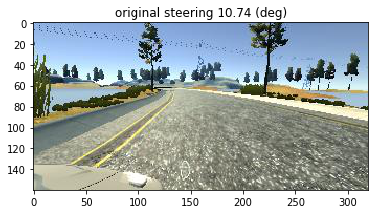

In [59]:
plt.imshow(np.uint8(sample_x));
plt.title('original steering '+str(np.round(sample_y*180/3.14159,2))+' (deg)');

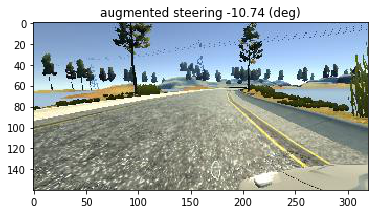

In [60]:
plt.imshow(np.uint8(aug_x[0]));
plt.title('augmented steering '+str(np.round(aug_y[0]*180/3.14159,2))+' (deg)');

## Steering Angle Distribution

As is the case in all machine learning tasks, we want to confident our model is actually making use of the input features, and not learning a generalization of the univariate targets.  In order to asses that, we look at the steering angle distribution and compute a base line mean-sqaure error (MSE) optimal value (the mean of the target data as a single optimal parameter) so that we can know, if our model is outperforming this value significantly or making only slight use of the input features to find a correlation.

In [61]:
y_targs = np.concatenate((y,-y))

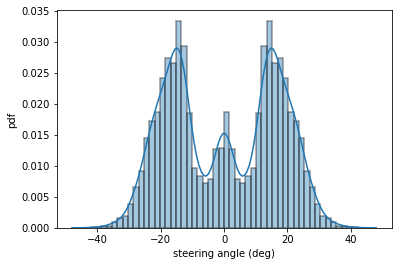

In [63]:
sns.distplot((y_targs*180/np.pi),norm_hist=True,hist_kws=dict(edgecolor="k", linewidth=1.5));
plt.xlabel("steering angle (deg)");
plt.ylabel("pdf");

In [64]:
mean_targs = np.mean(y_targs)
base_mse = np.mean((y_targs-mean_targs)**2)
print('Base MSE score from mean steering angle: ', np.round(base_mse,2))

Base MSE score from mean steering angle:  0.09


In [65]:
# optional pickling of the data
with open('./imgs_steer_paths.pkl','wb') as f:
    pickle.dump(sample_paths,f)

In [ ]:
# optional load of pickled data
with open('./imgs_steer_paths.pkl','rb') as f:
    sample_paths = pickle.load(f)

## Train and Validation Data Split

I used $20\%$ of the data as validation data and didn't generate any test set as this isn't going to be used in production, so knowing how it would perform "in the wild" isn't really necessary for this task.

In [67]:
# spliting into a train,validation set, split arrays 
# or matrices into random train and test subsets
train_img_paths,valid_img_paths,train_angles,valid_angles = train_test_split(X,y,test_size=0.2,random_state=1337)

## Creating a Runtime Data Generator

Each image in the data set is stored by matplotlib's imread function as a $160\times320\times3$ array where each value can take a value between $0-255$.  This would mean the total dataset after augmentation would take up about 75 GB alone!  Obviously we can't load all the data into a single machine memory, so to overcome this issue we are going to use a data generator, such that a mini-batch of images is loaded into memory used along with a stochastic gradient decent we can train our model and immediately release the image data and continuously load new images from the training data.  To do this we create a data generator using the `yield` command from python in the function below, such that mini-batch of size `2*batch_rows` of randomized images is returned with the associated steering angle targets.  As a final note, the RGB color channels are converted to YUV color channels before being input to the network, for reasons explained in the next section.

In [86]:
def data_generator_from_file(paths,targs,batch_rows=32):
    num_rows = len(paths)
    samples,targs = shuffle(paths,targs)
    
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_rows, batch_rows):
            batch_samples = samples[offset:offset+batch_rows]
            batch_targs = targs[offset:offset+batch_rows]
            
            #initialize batch arrays
            images = []
            angles = []
            
            for sample,steer in zip(batch_samples,batch_targs):
                img = plt.imread(sample)
                #img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV) #color channel convert turned off in the notebook
                images.append(img)
                angles.append(steer)
            
            images = np.array(images)
            angles = np.array(angles)
            
            # apply the augmentation steps
            X_train_batch,y_train_batch = augment(images,angles)
            
            yield X_train_batch, y_train_batch

In [103]:
#generate an example mini-batch
for x_samples,y_samples in data_generator_from_file(train_img_paths,train_angles,2):
    break

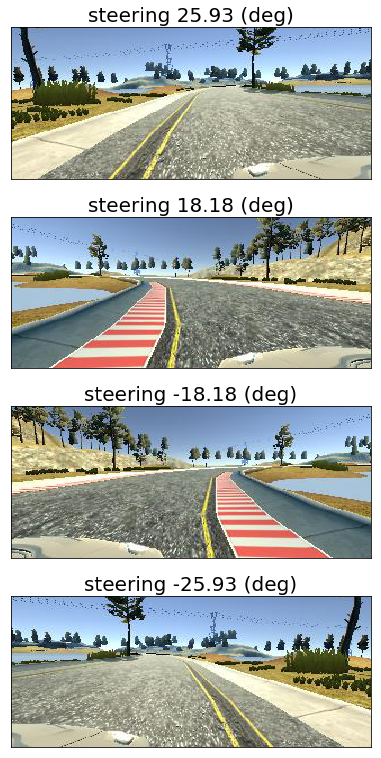

In [118]:
# visualize some samples from the generator
fig = plt.figure(figsize=(5,10))
fig.subplots_adjust(left=0,right=1,bottom=0,top=1,hspace=0.25,wspace=0.05)

for i,x_sample,y_sample in zip(range(4),x_samples,y_samples):
    title ='steering '+str(np.round(y_sample*180/3.14159,2))+' (deg)'
    img = np.uint8(x_sample)
    axis = fig.add_subplot(4,1,i + 1, xticks=[], yticks=[])
    plt.title(title,fontsize=20)
    axis.imshow(img,aspect="auto")

plt.show()

In [ ]:
# Make the data generator objects for training and validation datasets
# Set our batch size
batch_size = 128 #so we will have 256 images and targets per mini-batch

# compile and train the model using the generator function
train_generator_obj = data_generator_from_file(train_img_paths,train_angles,batch_size)
validation_generator_obj = data_generator_from_file(valid_img_paths,valid_angles,batch_size)

## Model Generation

In order to go from center camera image to steering angle, a convolutional neural network nearly identical to the model described here [End to End Learning for Self-Driving Cars](https://arxiv.org/pdf/1604.07316v1.pdf) used by Nvidia researchers M. Bojarski *et al*, to map simulated and real world images to steering angles is employed. The Nvidia model explicitly mentions use of the YUV color channels rather than RGB color channels. This likely helps the network identify lane markings as useful features in various lighting conditions and therefore is used in my network, though I did not check if it empirically made any difference in network performance. The only modification to the network is that data standardization (mean centering and variance set to 1) along with image cropping to an area of interest is done within the network, as well as the inclusion of batch normalization layers through out.  The batch normalization layers, both speed up training and act as regularizers for the generalization of the driving task.  An image of the network architecture is done below where I've omitted the cropping and standardization step.

<img src="covnet_diagram.jpg" alt="drawing" width="700"/>

The area of interest cropping, is done in such a way that the image is focusing on the road way directly in front of the vehicle such that distant features or features found in the sky can not play a role in determining steering angle.  The side effect of this is that this network can only perform well on roads that have almost no inclinations, as you can imagine a case where the cropped image will inadvertently contain the road-sky horizon when approaching the top of a hill.  I do not know how the network would react to strong horizontal gradients like that and it would be an out-of-sample result.  I show below a sample of an original input image, and its cropped version so you can see what section of the road is being analyzed during the training. 

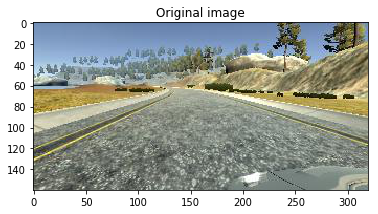

In [92]:
ridx = 0
plt.imshow(np.uint8(x_sample[ridx]));
plt.title('Original image');

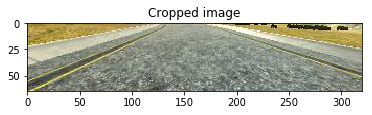

In [93]:
plt.imshow(np.uint8(x_sample[ridx][65:-30,:]));
plt.title('Cropped image');

I suspect that since this network is used on a much larger data set in the Nvidia trial that this network is major overkill as it has $560,211$ free parameters on something like $65,850$ images and one area of additional research would be to reduce the network complexity to find the minimal functioning model for the task.

In [122]:
def generate_nvidia_model():
    in_rows,in_cols = 160,320
    # define the CNN you want to use with preprocessing layers
    model = Sequential()
    #preprocessing
    model.add(Lambda(lambda x: (x-127.5)/127.5,input_shape=(in_rows,in_cols,3)))
    model.add(Cropping2D(cropping=((65,30),(0,0))))
    
    #NETWORK
    #conv_layer1
    model.add(Convolution2D(filters=24,kernel_size=5,strides=(2,2),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    #conv_layer2
    model.add(Convolution2D(filters=36,kernel_size=5,strides=(2,2)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    #conv_layer3
    model.add(Convolution2D(filters=48,kernel_size=5,strides=(2,2)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    #conv_layer4
    model.add(Convolution2D(filters=64,kernel_size=3,strides=(1,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    #conv_layer5
    model.add(Convolution2D(filters=64,kernel_size=3,strides=(1,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    #FC layers
    # stack outputs in a flattened vector
    model.add(Flatten())

    model.add(Dense(100))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(50))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(10))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    #steering angle
    model.add(Dense(1))
    
    return model

In [123]:
my_model = generate_nvidia_model()

Instructions for updating:
Colocations handled automatically by placer.


In [124]:
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d (Cropping2D)      (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 33, 160, 24)       1824      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 33, 160, 24)       96        
_________________________________________________________________
activation (Activation)      (None, 33, 160, 24)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 78, 36)        21636     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 15, 78, 36)        144       
__________

## Model Training

I trained this model on a Nvidia Tesla K80 GPU provided to me by Udacity, using the keras built ADAM optimizer along with mean square error as the loss function for this network.  Without a GPU this would take a very very long time to compute the network parameters, however the code to do so is provided below.  After training for 4 epochs which took $16$ minutes, my final result was a training loss of $0.0022$ and a validation loss of $0.0029$, which obviously is better than the baseline error.

In [432]:
model.compile(loss='mse',optimizer='adam')

In [ ]:
history_object = model.fit_generator(train_generator_obj, 
                                     steps_per_epoch=np.ceil(len(train_sample_paths)/batch_size),
                                     validation_data=validation_generator_obj,
                                     validation_steps=np.ceil(len(valid_sample_paths)/batch_size), 
                                     epochs=1,
                                     verbose=1)

In [152]:
# load of pickled training data from cloud training session
with open('./train_history.pkl','rb') as f:
    history = pickle.load(f)

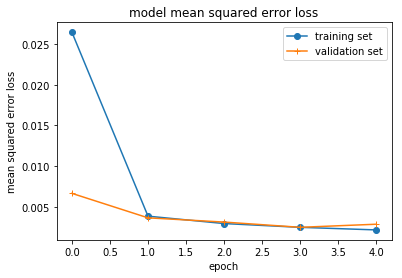

In [157]:
# plot the training and validation loss for each epoch from the pickled
# training results from the Nvidia Tesla K80
plt.plot(history[0],marker='o')
plt.plot(history[1],marker='+')
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

## Model Validation

In order to properly test the network, Udacity provides a script `drive.py` which when provided a HDF5 file of a training network will connect to driving simulator and feed center camera images to the network and send steering commands to the car as well as maintain a 9 mph vehicle speed (different from that of the training data).  

The car was able to successfully navigate the track, though, in some areas the car performs in a way that I would not enjoy as a person riding in the car (rapid steering corrections). A video of the autonomous driving was generated using the `video.py` script and is provided [here](./track1_lap.mp4) and below, note the playback is twice the speed.

In [168]:
from IPython.display import HTML
HTML('<iframe width="250" height="150" src="./track1_lap.mp4" frameborder="0" allowfullscreen></iframe>')

/Users/bvlcek/anaconda2/envs/py3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


I believe because the track is brightly lit in the majority of the training images, that the network's inexperience with shadows make it behave oddly in these situations and further augmentation by random lightening and darkening of images, or additional training data with more samples of shadows would eliminate this behavior. I also believe incorporating steering angle smoothing to the controller such as exponential smoothing would reduce this behavior such that a sequence of images steering angle is what the controller uses for input rather than single frame steering inputs.  As a final validation check of this network, I also positioned the car in the opposite direction of the training data so that the circuit would need to be transervsed in the anti-clockwise direction.  The car was able to successfully navigate the track in the opposite direction as well.  

## Final Notes

The model does perform the task well and drives the track with out the aid of a human, however, I would be surprised if model would generalize well to other tracks that have significant evaluation changes, changes in road texture different from the training set, significant number of shadows over the roadway, and significantly different lighting conditions. To overcome all of these issues I believe a lane finding + vanishing point finding algorithm would need to be used to find appropriate cropping areas and then feed a resized image to the network of a properly cropped image to the network. Further training data would be needed for the network to overcome shadow effects, and different lighting conditions.  Though random darkening and brightening of training data could help with the training for different lighting conditions.  It would also be interesting to reduce the network down to its bare minimum to number of layers and find what are the convolution feature maps that the network finds useful for insight to making this type of network perform better in more varied situations.